In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Analysis

In this analysis I will be looking to answer the question what attributes, that differ from the general population of music, are typical of songs taken from a subset of playlists.

-----------------
$H_o$: The attributes of songs in specified playlists are no different than the general population.

$H_a$: The attributes of songs in specified playlists are measurably different than the general population

--------------

Taking it another step further, we will be processing the data to try and establish a set of unique attributes intended to be used as creative guidelines for musicians.

First, I will be covering songs found in "running" playlists. Then, I will do a similar analysis with songs found in "study" playlists. The attributes covered will include tempo, valence (mood), instrumentalness, energy, and acousticness. I will explain what each of those mean as we go on but you can find explanations [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from non_param_effect_size import calc_non_param_ci, cles_ind, rbc_ind

%matplotlib inline


def get_95_ci(x1, x2):
    """Calculate a 95% CI for 2 1d numpy arrays"""
    signal = x1.mean() - x2.mean()
    noise = np.sqrt(x1.var() / x1.size + x2.var() / x2.size)

    ci_lo = signal - 1.96 * noise
    ci_hi = signal + 1.96 * noise

    return ci_lo, ci_hi

<IPython.core.display.Javascript object>

In [1]:
# initialize colors to be used for visualizations
gen_bar_color = "#97D1FB"  # pale blue
gen_line_color = "#49ECF2"  # cyan

run_bar_color = "#AC1900"  # red
run_line_color = "#CD5D00"  # orange

stud_bar_color = "#8BE413"  # green
stud_line_color = "#8BE413"  # green

### Run, Run, Run

First, I would like to outline some base assumptions we might have about how a 'running' song may differ from the crowd. I personally am not a runner but if I were to create a running playlist, these are some of the attributes I would look for:
- [ ] Fast
- [ ] Energetic
- [ ] Uplifting

Fast to push my pace. Energetic to pump me up. And uplifting to escape from the pain.

In [4]:
running = pd.read_csv("../data/running_playlist_tracks.csv")
running.drop(columns="Unnamed: 0", inplace=True)
gen = pd.read_csv("../data/sampled_set.csv")
gen.drop(columns="Unnamed: 0", inplace=True)

<IPython.core.display.Javascript object>

#### Up the Tempo

The internal clock of a song is measured in BPM or beats per minute. The higher the BPM. the faster the song.

-----------
The hypotheses:

$H_o$: The average tempo of running playlist songs is the *same* as the general population

$H_a$: The average tempo of running playlist songs is *higher* than the general population

-----------

Let's start by just looking at the distributions:

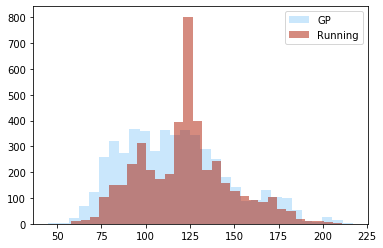

<IPython.core.display.Javascript object>

In [5]:
# Get rid of zeros because they represent either incomplete or erroneous data.
gen_filtered = gen[gen["tempo"] != 0]
run_filtered = running[running["tempo"] != 0]
gen_filtered["tempo"].hist(bins=30, alpha=0.5, label="GP", color=gen_bar_color)
run_filtered["tempo"].hist(bins=30, alpha=0.5, label="Running", color=run_bar_color)
plt.legend()
plt.grid(b=None)
plt.show()

There's an obvious spike around 125 in the running playlist data. Let's run a quick test for normality before continuing on to a t-test

In [6]:
print(stats.describe(gen_filtered["tempo"]))
print(stats.describe(run_filtered["tempo"]))

DescribeResult(nobs=4995, minmax=(44.978, 216.843), mean=117.0567075075075, variance=923.1977151100659, skewness=0.5126162414952244, kurtosis=-0.2153056072706594)
DescribeResult(nobs=4454, minmax=(57.967, 216.334), mean=122.51974449932646, variance=659.8384563128767, skewness=0.33999720681387696, kurtosis=0.09191662790906507)


<IPython.core.display.Javascript object>

In [7]:
_, p = stats.ttest_ind(gen_filtered["tempo"], run_filtered["tempo"])
print(p)

8.304645583849454e-21


<IPython.core.display.Javascript object>

The t-test comes out with a pretty definitive p value of ~ $8.3 * {10}^{-21}$

A 95% confidence interval will give us a good idea of how different they really are.

In [8]:
l, h = get_95_ci(run_filtered["tempo"], gen_filtered["tempo"])

low = gen_filtered["tempo"].mean() + l
high = gen_filtered["tempo"].mean() + h

(low, high)
l, h

print(
    f"The confidence interval returns a range of {round(l, 2)} and {round(h, 2)} beats per minute higher than the population average"
)

print(
    f"This give a range of {round(low,1)} and {round(high, 1)} BPM when compared to the average of the population"
)

The confidence interval returns a range of 4.33 and 6.59 beats per minute higher than the population average
This give a range of 121.4 and 123.7 BPM when compared to the average of the population


<IPython.core.display.Javascript object>

The range of 121.4 to 123.7 gives us a good ballpark of where the middle is at least in relation to the overall population. However, now that we have established there is in fact a difference, I think a more poignant bit of data would be looking at the summary of only the running playlist songs.

Not only is the average among running songs higher, the range is significantly narrower as well.

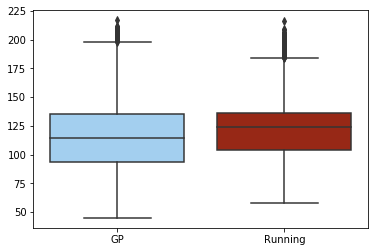

<IPython.core.display.Javascript object>

In [9]:
gen_temp = pd.DataFrame(data=gen_filtered["tempo"])
gen_temp = gen_temp.rename(columns={"tempo": "gen"})
run_temp = pd.DataFrame(run_filtered["tempo"])
run_temp = run_temp.rename(columns={"tempo": "run"})

box_df_tempo = pd.concat([gen_temp, run_temp], axis=1)

bp = sns.boxplot(data=box_df_tempo, palette=[gen_bar_color, run_bar_color])
bp.set_xticklabels(("GP", "Running"))
plt.show()

In [10]:
gm = gen_filtered["tempo"].mean()
gs = gen_filtered["tempo"].std()
rm = run_filtered["tempo"].mean()
rs = run_filtered["tempo"].std()

print(
    f"The range of BPM as defined by the mean({round(rm,1)}) +/- standard deviation is {round(rm-rs, 1)} to {round(rm+rs, 1)}"
)

The range of BPM as defined by the mean(122.5) +/- standard deviation is 96.8 to 148.2


<IPython.core.display.Javascript object>

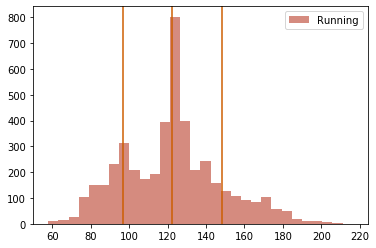

<IPython.core.display.Javascript object>

In [47]:
run_filtered["tempo"].hist(bins=30, alpha=0.5, label="Running", color=run_bar_color)

# put lines at the mean and +- standard deviation

plt.axvline(x=rm, color=run_line_color)
plt.axvline(x=rm + rs, color=run_line_color)
plt.axvline(x=rm - rs, color=run_line_color)

plt.legend()
plt.grid(b=None)
plt.show()

96.8 to 148.2 is too wide of a range and seems to include some possibly unfavorable BPMs

In [12]:
print(
    f'The range given as a function of IQR is {round(run_filtered["tempo"].describe()["25%"],1)} to {round(run_filtered["tempo"].describe()["75%"],1)} '
)

The range given as a function of IQR is 104.0 to 136.0 


<IPython.core.display.Javascript object>

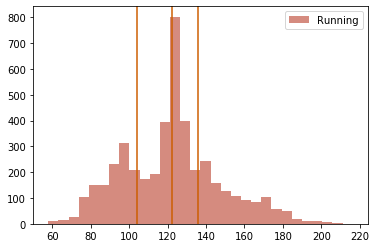

<IPython.core.display.Javascript object>

In [48]:
run_filtered["tempo"].hist(bins=30, alpha=0.5, label="Running", color=run_bar_color)

# put lines at the mean and  IQR

plt.axvline(x=rm, color=run_line_color)
plt.axvline(x=run_filtered["tempo"].describe()["25%"], color=run_line_color)
plt.axvline(x=run_filtered["tempo"].describe()["75%"], color=run_line_color)

plt.legend()
plt.grid(b=None)
plt.show()

A BPM between 104 and 136 could be deemed acceptable, but considering the density around the mean, I think it would be wise to stick as close to 122 BPM as possible.

---------
In the context of our initial assumption about wanting faster songs in our running playlists, we are able to reject the null and confirm our belief. However, on the whole, running songs are only 4 to 7 BPM higher. Upon looking at purely the running songs, we are able to create a safe range with an emphasis on sticking close to the mean of 122.

Looking back to our initial checklist, we can cross fast off with a note to optimal BPM.

- [x] Fast (122 BPM)
- [ ] Energetic
- [ ] Uplifting

### An object in motion...

Moving on to "energetic" we'll be looking at the "energy" metric [which is defined](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) as such:
>Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

----------
The hypotheses we will be testing:

$H_o$: The average energy level of running playlist songs is the *same* as the general population

$H_a$: The average energy level of running playlist songs is *higher* than the general population

---------------

Let's check the distributions first.

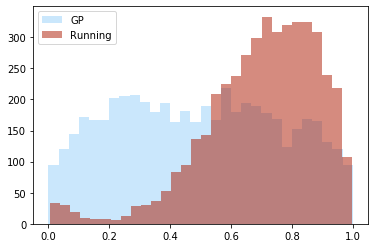

<IPython.core.display.Javascript object>

In [14]:
gen["energy"].hist(bins=30, alpha=0.5, color=gen_bar_color, label="GP")
running["energy"].hist(bins=30, alpha=0.5, color=run_bar_color, label="Running")
plt.legend()
plt.grid(b=None)
plt.show()

Pretty definitive just by looking at it but we will do some quick analysis for posterity.

In [15]:
print(stats.describe(running["energy"]))
print(stats.describe(gen["energy"]))

DescribeResult(nobs=4455, minmax=(0.00561, 0.997), mean=0.6993501571268238, variance=0.034823354923459816, skewness=-1.0478527833385225, kurtosis=1.506434259458909)
DescribeResult(nobs=5000, minmax=(0.0, 0.999), mean=0.49023799132, variance=0.07200988148859735, skewness=0.05983787850779529, kurtosis=-1.1116880449765025)


<IPython.core.display.Javascript object>

Kurtosis is a little high for both but still low enough to be treated as normal

In [16]:
_, p = stats.ttest_ind(running["energy"], gen["energy"])
p

0.0

<IPython.core.display.Javascript object>

The p-value is so low the function rounds it down to zero, thus confirming our suspicion.

In [17]:
l, h = get_95_ci(running["energy"], gen["energy"])
l, h
print(
    f"On average, the energy level of running songs is {round(l,3)} to {round(h,3)} energy points higher than general population"
)
rem = running["energy"].mean()
print(f"The average energy level of running songs is {round(rem, 3)}")

On average, the energy level of running songs is 0.2 to 0.218 energy points higher than general population
The average energy level of running songs is 0.699


<IPython.core.display.Javascript object>

Considering the definition put forth by Spotify for what "energy" means, 0.2 to 0.218 "energy points" is highly subject to interpretation. At the very least we are able to reject the null and point out that, to a certain degree, busier, louder, more energetic songs are more likely to be put on to a running playlist. 

- [x] Fast (122 BPM)
- [x] Energetic
- [ ] Uplifting

### Big Mood

Lastly, we'll look at how "uplifting" the songs are in running playlists. This is by far the most subjective of the three so it should be pointed out we should be careful with our conclusions on this matter. To measure this, we will be looking at the "valence" metric Spotify has which is [defined as](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/):

> A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

So for us, we'll be taking a higher valence score to mean that a song is more uplifting.

---------------

The hypotheses we will be testing:

$H_o$: The average valence of running playlist songs is the *same* as the general population

$H_a$: The average valence of running playlist songs is *higher* than the general population

---------------

Let's check the distributions first.

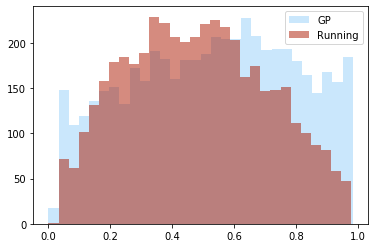

<IPython.core.display.Javascript object>

In [18]:
gen["valence"].hist(bins=30, alpha=0.5, color=gen_bar_color, label="GP")
running["valence"].hist(bins=30, alpha=0.5, color=run_bar_color, label="Running")
plt.legend()
plt.grid(b=None)
plt.show()

That's a little bit surprising. It looks as though running playlist songs are on the whole *less* positive than the general population.

In [19]:
# check for normality
print(stats.describe(running["valence"]))
print(stats.describe(gen["valence"]))
# close enough

DescribeResult(nobs=4455, minmax=(0.0, 0.979), mean=0.4798855667789001, variance=0.05122042288772875, skewness=0.12503156096502394, kurtosis=-0.841613763018974)
DescribeResult(nobs=5000, minmax=(0.0, 0.984), mean=0.5300693280000001, variance=0.06850174344963834, skewness=-0.12409209967838768, kurtosis=-1.0387476268367954)


<IPython.core.display.Javascript object>

In [20]:
_, p = stats.ttest_ind(running["valence"], gen["valence"])
p

4.6661619210136584e-23

<IPython.core.display.Javascript object>

In [21]:
l, h = get_95_ci(running["valence"], gen["valence"])
l, h
print(
    f"On average, the valence of running songs is {abs(round(h,3))} to {abs(round(l,3))} energy points lower than general population"
)
rvm = running["valence"].mean()
print(f"The average valence of running songs is {round(rvm, 3)}")

On average, the valence of running songs is 0.04 to 0.06 energy points lower than general population
The average valence of running songs is 0.48


<IPython.core.display.Javascript object>

We do not confirm our initial assumption that running songs are more upbeat, but we are at least able to reject the null that the average "mood" (valence) is the same as the general population. Looking at the 95% confidence interval, it could be argued that the difference in means isn't substantial enough to for an actionable insight using the data. Although, I do think we can say with some amount of confidence that it is safer to err on the side of less positive sounding songs. 

A final look at our checklist

- [x] Fast (122 BPM)
- [x] Energetic
- [ ] ~~Uplifting~~


(One final note, maybe don't make an acoustic song)

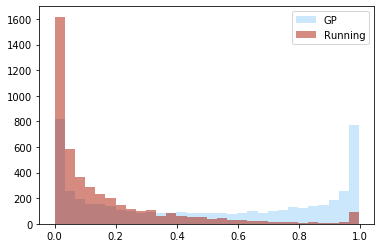

<IPython.core.display.Javascript object>

In [22]:
gen["acousticness"].hist(bins=30, alpha=0.5, color=gen_bar_color, label="GP")
running["acousticness"].hist(bins=30, alpha=0.5, color=run_bar_color, label="Running")
plt.legend()
plt.grid(b=None)
plt.show()

In [23]:
_, p = stats.mannwhitneyu(running["acousticness"], gen["acousticness"])
p  # Again, p is so low it gets rounded to 0

0.0

<IPython.core.display.Javascript object>

In [24]:
h, l = calc_non_param_ci(running["acousticness"], gen["acousticness"])
cles_aco = cles_ind(running["acousticness"], gen["acousticness"])
rbc_aco = rbc_ind(running["acousticness"], gen["acousticness"])

print(
    f"On average the 'acousticness' is {abs(round(l, 2))} to {abs(round(h, 2))} points lower"
)
print(f"The Common Language Effect Size is {round(cles_aco, 2)}")
print(f"The Ranked Biserial Correlation is {round(rbc_aco, 2)}")

On average the 'acousticness' is 0.29 to 0.33 points lower
The Common Language Effect Size is 0.74
The Ranked Biserial Correlation is 0.49


<IPython.core.display.Javascript object>

All of this points to a strong conclusion that making an acoustic song is a bad idea if your goal is to get on running playlists.

## Final Thoughts on Running Playlists

Everything considered, we are able to confidently reject the overall null hypothesis that the attributes of running songs are no different than the general population. Digging a bit deeper, we are able to establish a set of guidelines that a musician can reference if their goal is to get their music on playlists used for running. 

Definitively:
- Fast tempo around 122 BPM
- High energy
- Not acoustic

And not so definitively:

- Less positive overall mood

It is important to note here that the data used to represent the general population skews significantly from what is shown on the API reference documentation. There is a clear bias towards acoustic music and, consqeuently, the energy is more normal as opposed to skewing towards higher energy. That being said, I am still confident in the conclusions drawn from data at hand but it might be worth revisiting after coming up with a better way of sampling the general population.

### Study, Study, Study

Now that we have established a method of generating guidelines based on a subset of music, I would like to take some time to consider another type of playlist common to people's libraries: study playlists. This time I will not bother with creating a list of assumptions to check, but rather highlight some of the more interesting differences to make another set of song guidelines.

Starting again with tempo.

In [25]:
study = pd.read_csv("../data/study_playlist_tracks.csv")
study.drop(columns="Unnamed: 0", inplace=True)

<IPython.core.display.Javascript object>

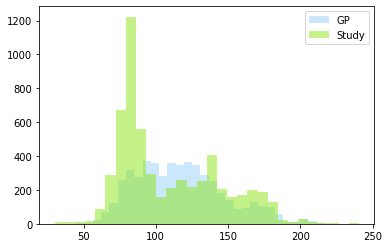

<IPython.core.display.Javascript object>

In [26]:
# Get rid of zeros because they represent either incomplete or erroneous data.
# gen_filtered = gen[gen["tempo"] != 0]
stud_filtered = study[study["tempo"] != 0]
gen_filtered["tempo"].hist(bins=30, alpha=0.5, label="GP", color=gen_bar_color)
stud_filtered["tempo"].hist(bins=30, alpha=0.5, label="Study", color=stud_bar_color)
plt.legend()
plt.grid(b=None)
plt.show()

Much like the running playlist data, we see a high density around one tempo in particular, although this time much lower than before.

In [27]:
print(stats.describe(gen_filtered["tempo"]))
print(stats.describe(stud_filtered["tempo"]))
# normal enough for a t-test

DescribeResult(nobs=4995, minmax=(44.978, 216.843), mean=117.0567075075075, variance=923.1977151100659, skewness=0.5126162414952244, kurtosis=-0.2153056072706594)
DescribeResult(nobs=5809, minmax=(30.015, 240.645), mean=108.94365570666207, variance=1233.2558286431497, skewness=0.7105359054376775, kurtosis=-0.521043370654072)


<IPython.core.display.Javascript object>

In [28]:
_, p = stats.ttest_ind(gen_filtered["tempo"], run_filtered["tempo"])
print(p)
# very low p-value

8.304645583849454e-21


<IPython.core.display.Javascript object>

In [29]:
l, h = get_95_ci(stud_filtered["tempo"], gen_filtered["tempo"])

low = gen_filtered["tempo"].mean() + l
high = gen_filtered["tempo"].mean() + h

(low, high)
l, h

print(
    f"The confidence interval returns a range of {abs(round(h, 2))} and {abs(round(l, 2))} beats per minute lower than the population average"
)

print(
    f"This give a range of {round(low,1)} and {round(high, 1)} BPM when compared to the average of the population"
)

The confidence interval returns a range of 6.88 and 9.35 beats per minute lower than the population average
This give a range of 107.7 and 110.2 BPM when compared to the average of the population


<IPython.core.display.Javascript object>

The confidence interval is different enough to warrant establishing a guideline. Let's look at the IQR and mean to create a range.

In [30]:
print(
    f'The range given as a function of IQR is {round(stud_filtered["tempo"].describe()["25%"],1)} to {round(stud_filtered["tempo"].describe()["75%"],1)} '
)
m = stud_filtered["tempo"].mean()
print(f"The average tempo of study songs is {round(m, 1)}")

The range given as a function of IQR is 80.1 to 137.7 
The average tempo of study songs is 108.9


<IPython.core.display.Javascript object>

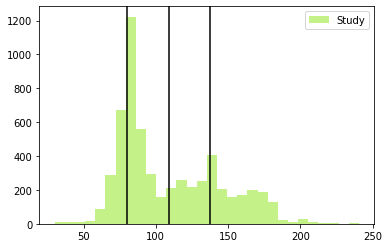

<IPython.core.display.Javascript object>

In [31]:
stud_filtered["tempo"].hist(bins=30, alpha=0.5, label="Study", color=stud_bar_color)

# show the IQR along with the mean

plt.axvline(x=m, color="#000000")
plt.axvline(x=stud_filtered["tempo"].describe()["25%"], color="#000000")
plt.axvline(x=stud_filtered["tempo"].describe()["75%"], color="#000000")

plt.legend()
plt.grid(b=None)
plt.show()

In [32]:
import math

# round all the tempos down to find a mode.
rounded_tempo = []

for t in stud_filtered["tempo"]:
    rounded_tempo.append(math.floor(t))

# convert to a dataframe for function calls
rounded_tempo = pd.DataFrame(rounded_tempo)
rounded_tempo.mode()

0
0  80

<IPython.core.display.Javascript object>

This one is a little more difficult to interpret. Looking at the distribution with the IQR, going with the mean doesn't seem fit. My gut is to go with the bottom of the range where the highest density of tempos resides, 80 BPM. A quick look at the mode matches up with that perspective. As such, we can establish a guideline that, although tempos ranging all the way from 80 to 137 could be deemed acceptable, it would be best to stick right around 80 BPM.

Let's check energy.

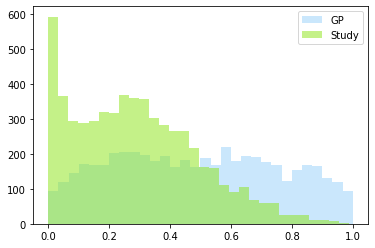

<IPython.core.display.Javascript object>

In [33]:
gen["energy"].hist(bins=30, alpha=0.5, color=gen_bar_color, label="GP")
study["energy"].hist(bins=30, alpha=0.5, color=stud_bar_color, label="Study")
plt.legend()
plt.grid(b=None)
plt.show()

Once again, we see a large disparity from the general population, this time possibly even more so and in the opposite direction. Let's back it up with some numbers.

In [34]:
print(stats.describe(study["energy"]))
print(stats.describe(gen["energy"]))
# normal enough

DescribeResult(nobs=5818, minmax=(0.00046100000000000004, 0.987), mean=0.28872202165692673, variance=0.04060156906616388, skewness=0.5583603008753037, kurtosis=-0.24422364224286586)
DescribeResult(nobs=5000, minmax=(0.0, 0.999), mean=0.49023799132, variance=0.07200988148859735, skewness=0.05983787850779529, kurtosis=-1.1116880449765025)


<IPython.core.display.Javascript object>

In [35]:
_, p = stats.ttest_ind(study["energy"], gen["energy"])
p
# So low it's rounded to zero

0.0

<IPython.core.display.Javascript object>

In [36]:
l, h = get_95_ci(study["energy"], gen["energy"])
l, h
print(
    f"On average, the energy level of study songs is {abs(round(h,3))} to {abs(round(l,3))} energy points lower than general population"
)
sem = study["energy"].mean()
print(f"The average energy level of study songs is {round(sem, 3)}")

On average, the energy level of study songs is 0.192 to 0.211 energy points lower than general population
The average energy level of study songs is 0.289


<IPython.core.display.Javascript object>

Not technically as large of a difference as the running songs but a clear enough level for us to establish another guideline. Lower energy tracks, especially very low energy tracks are optimal for study playlists. It could be interpreted that louder, busier songs are too distracting and cause the listener to lose focus.

Following down the line, we'll check the "valence" category to figure out the mood of the songs.

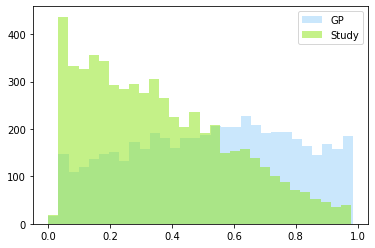

<IPython.core.display.Javascript object>

In [37]:
gen["valence"].hist(bins=30, alpha=0.5, color=gen_bar_color, label="GP")
study["valence"].hist(bins=30, alpha=0.5, color=stud_bar_color, label="Study")
plt.legend()
plt.grid(b=None)
plt.show()

In [38]:
print(stats.describe(study["valence"]))
print(stats.describe(gen["valence"]))
# normal enough

DescribeResult(nobs=5818, minmax=(0.0, 0.978), mean=0.35509652801650055, variance=0.05346957966475261, skewness=0.5754281647090203, kurtosis=-0.5292242064244168)
DescribeResult(nobs=5000, minmax=(0.0, 0.984), mean=0.5300693280000001, variance=0.06850174344963834, skewness=-0.12409209967838768, kurtosis=-1.0387476268367954)


<IPython.core.display.Javascript object>

In [39]:
_, p = stats.ttest_ind(study["valence"], gen["valence"])
p
# extremely low p yet again

4.7534147046343233e-281

<IPython.core.display.Javascript object>

In [40]:
l, h = get_95_ci(study["valence"], gen["valence"])
l, h
print(
    f"On average, the valence level of study songs is {abs(round(h,3))} to {abs(round(l,3))} valence points lower than general population"
)
svm = study["valence"].mean()
print(f"The average valence level of study songs is {round(svm, 3)}")

On average, the valence level of study songs is 0.166 to 0.184 valence points lower than general population
The average valence level of study songs is 0.355


<IPython.core.display.Javascript object>

Just like in the running songs we find that the valence level is lower than the general population, this time to a much greater degree. Unlike before, we can establish definitively that less "positive sounding" songs have a higher likelihood of getting on to study playlists.

Keeping with the theme, we'll check "acousticness"

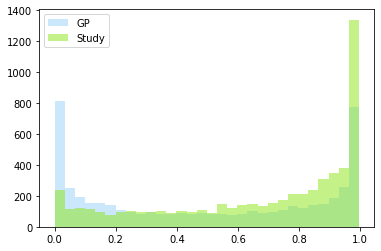

<IPython.core.display.Javascript object>

In [41]:
gen["acousticness"].hist(bins=30, alpha=0.5, color=gen_bar_color, label="GP")
study["acousticness"].hist(bins=30, alpha=0.5, color=stud_bar_color, label="Study")
plt.legend()
plt.grid(b=None)
plt.show()

In [42]:
_, p = stats.mannwhitneyu(gen["acousticness"], study["acousticness"])
p
# another infinitesimal p

1.2072303721679822e-134

<IPython.core.display.Javascript object>

In [43]:
h, l = calc_non_param_ci(study["acousticness"], gen["acousticness"])
cles_stu = cles_ind(study["acousticness"], gen["acousticness"])
rbc_stu = rbc_ind(study["acousticness"], gen["acousticness"])

print(
    f"On average the 'acousticness' is {abs(round(h, 2))} to {abs(round(l, 2))} points higher"
)
print(f"The Common Language Effect Size is {round(cles_stu, 2)}")
print(f"The Ranked Biserial Correlation is {round(rbc_stu, 2)}")


On average the 'acousticness' is 0.13 to 0.16 points higher
The Common Language Effect Size is 0.64
The Ranked Biserial Correlation is 0.27


<IPython.core.display.Javascript object>

This could be interpreted as a clear sign that acoustic tracks are better for study playlists. My issue with that conclusion is that one of the playlists has hundreds of solo piano songs. I will address a possible solution in the final conclusion. For now, we will establish that acoustic songs may be better considering the current data on hand.

--------------

One final metric I would like to look at solely for study playlists is "instrumentalness", defined:
> Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

It should be noted that this data may also be heavily skewed for the same reason mentioned above.

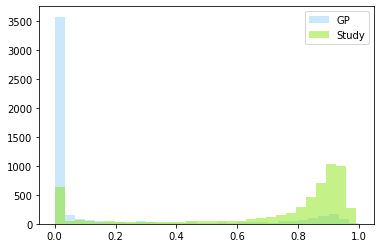

<IPython.core.display.Javascript object>

In [44]:
gen["instrumentalness"].hist(bins=30, alpha=0.5, color=gen_bar_color, label="GP")
study["instrumentalness"].hist(bins=30, alpha=0.5, color=stud_bar_color, label="Study")
plt.legend()
plt.grid(b=None)
plt.show()

In [45]:
_, p = stats.mannwhitneyu(gen["instrumentalness"], study["instrumentalness"])
p
# p is rounded down to 0

0.0

<IPython.core.display.Javascript object>

In [46]:
h, l = calc_non_param_ci(study["instrumentalness"], gen["instrumentalness"])
cles_ins = cles_ind(study["instrumentalness"], gen["instrumentalness"])
rbc_ins = rbc_ind(study["instrumentalness"], gen["instrumentalness"])

print(
    f"On average the 'instrumentalness' is {abs(round(h, 2))} to {abs(round(l, 2))} points higher"
)
print(f"The Common Language Effect Size is {round(cles_ins, 2)}")
print(f"The Ranked Biserial Correlation is {round(rbc_ins, 2)}")

On average the 'instrumentalness' is 0.77 to 0.8 points higher
The Common Language Effect Size is 0.85
The Ranked Biserial Correlation is 0.72


<IPython.core.display.Javascript object>

The evidence on this one is overwhelming and may possibly represent the largest deviation from the general population. From this, it's pretty easy to conclude that people do not like lyrics in their study playlists, allowing us to establish another guideline.

### Final Thoughts on Study Playlists

Looking solely at the numbers, it appears we can set forth an even narrower range of attributes to look for when identifying a song that is good for studying.

- Tempo around 80 BPM
- Low energy - quieter/less busy
- Sadder/More negative overall mood (valence)
- No lyrics

And with some caveats:

- Acoustic

# Conclusion

I feel very comfortable in rejecting the null for both subsets, "running" and "study". Many of the observations made confirmed my preconceptions, such as running songs being more energetic and studying songs having qualities that make them less distracting. The attributes derived from the analysis help inform a set of guidelines for each subset. My hope is to provide musicians with a bit of inspiration, which is sometimes all that is needed to create something truly incredible.
<br>
<br>
There are a few ways this analysis could be greatly improved. Concerning the bias in the data set meant to represent the general population, some thought into how to better sample the data so that it matches the distributions listed in the [API](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) would give a much more accurate picture. I'm genuinely unsure of how to do so and would require experimentation with the API. When it comes to the playlist data, I think limiting the size of the playlists to draw from would result in a wider variety of music and possibly some better insights for creating guidelines.
<br>
<br>
I'd like to leave this off with what I found to be one of the more profound observations out of this whole process that, admittedly, is outside the scope of the data. Nonetheless, the lower "valence" score for both types of playlists confirms a belief I hold, which is that music isn't as much about escapism than many other forms of media. To paraphrase something I've heard in the past, **"music gives us the space to fully realize our own emotions"**. Neither studying nor running can really be considered leisure, and in many cases they can both be quite painful. The music we listen to in these moments is a tool, not to escape the arduous task at hand, but to reinforce our mental state and persevere through what challenges us.
<br>
<br>
Thank you for taking the time to read this. I hope you can take something away from it.